In [47]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, average_precision_score, auc, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [79]:
# read the given input data file for training the model
data = pd.read_csv('Fraud_Detection_Dataset.csv')
data = data.dropna(subset=['Response']) # dropping rows with null/NaN values in response
      
# dropping the response column and seperating the predictors from the training dataset
X_dataset = data.drop('Response', axis=1)

# storing the response data sepeartely from the training dataset
y_dataset = data['Response']

# checking for null values
X_dataset.isna().sum()

X1      0
X2      0
X3      0
X4      0
X5      0
       ..
X196    0
X197    0
X198    0
X199    0
X200    0
Length: 200, dtype: int64

In [49]:
# Defining numerical and categorical features
numerical_features = X_dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_dataset.select_dtypes(include=['object']).columns

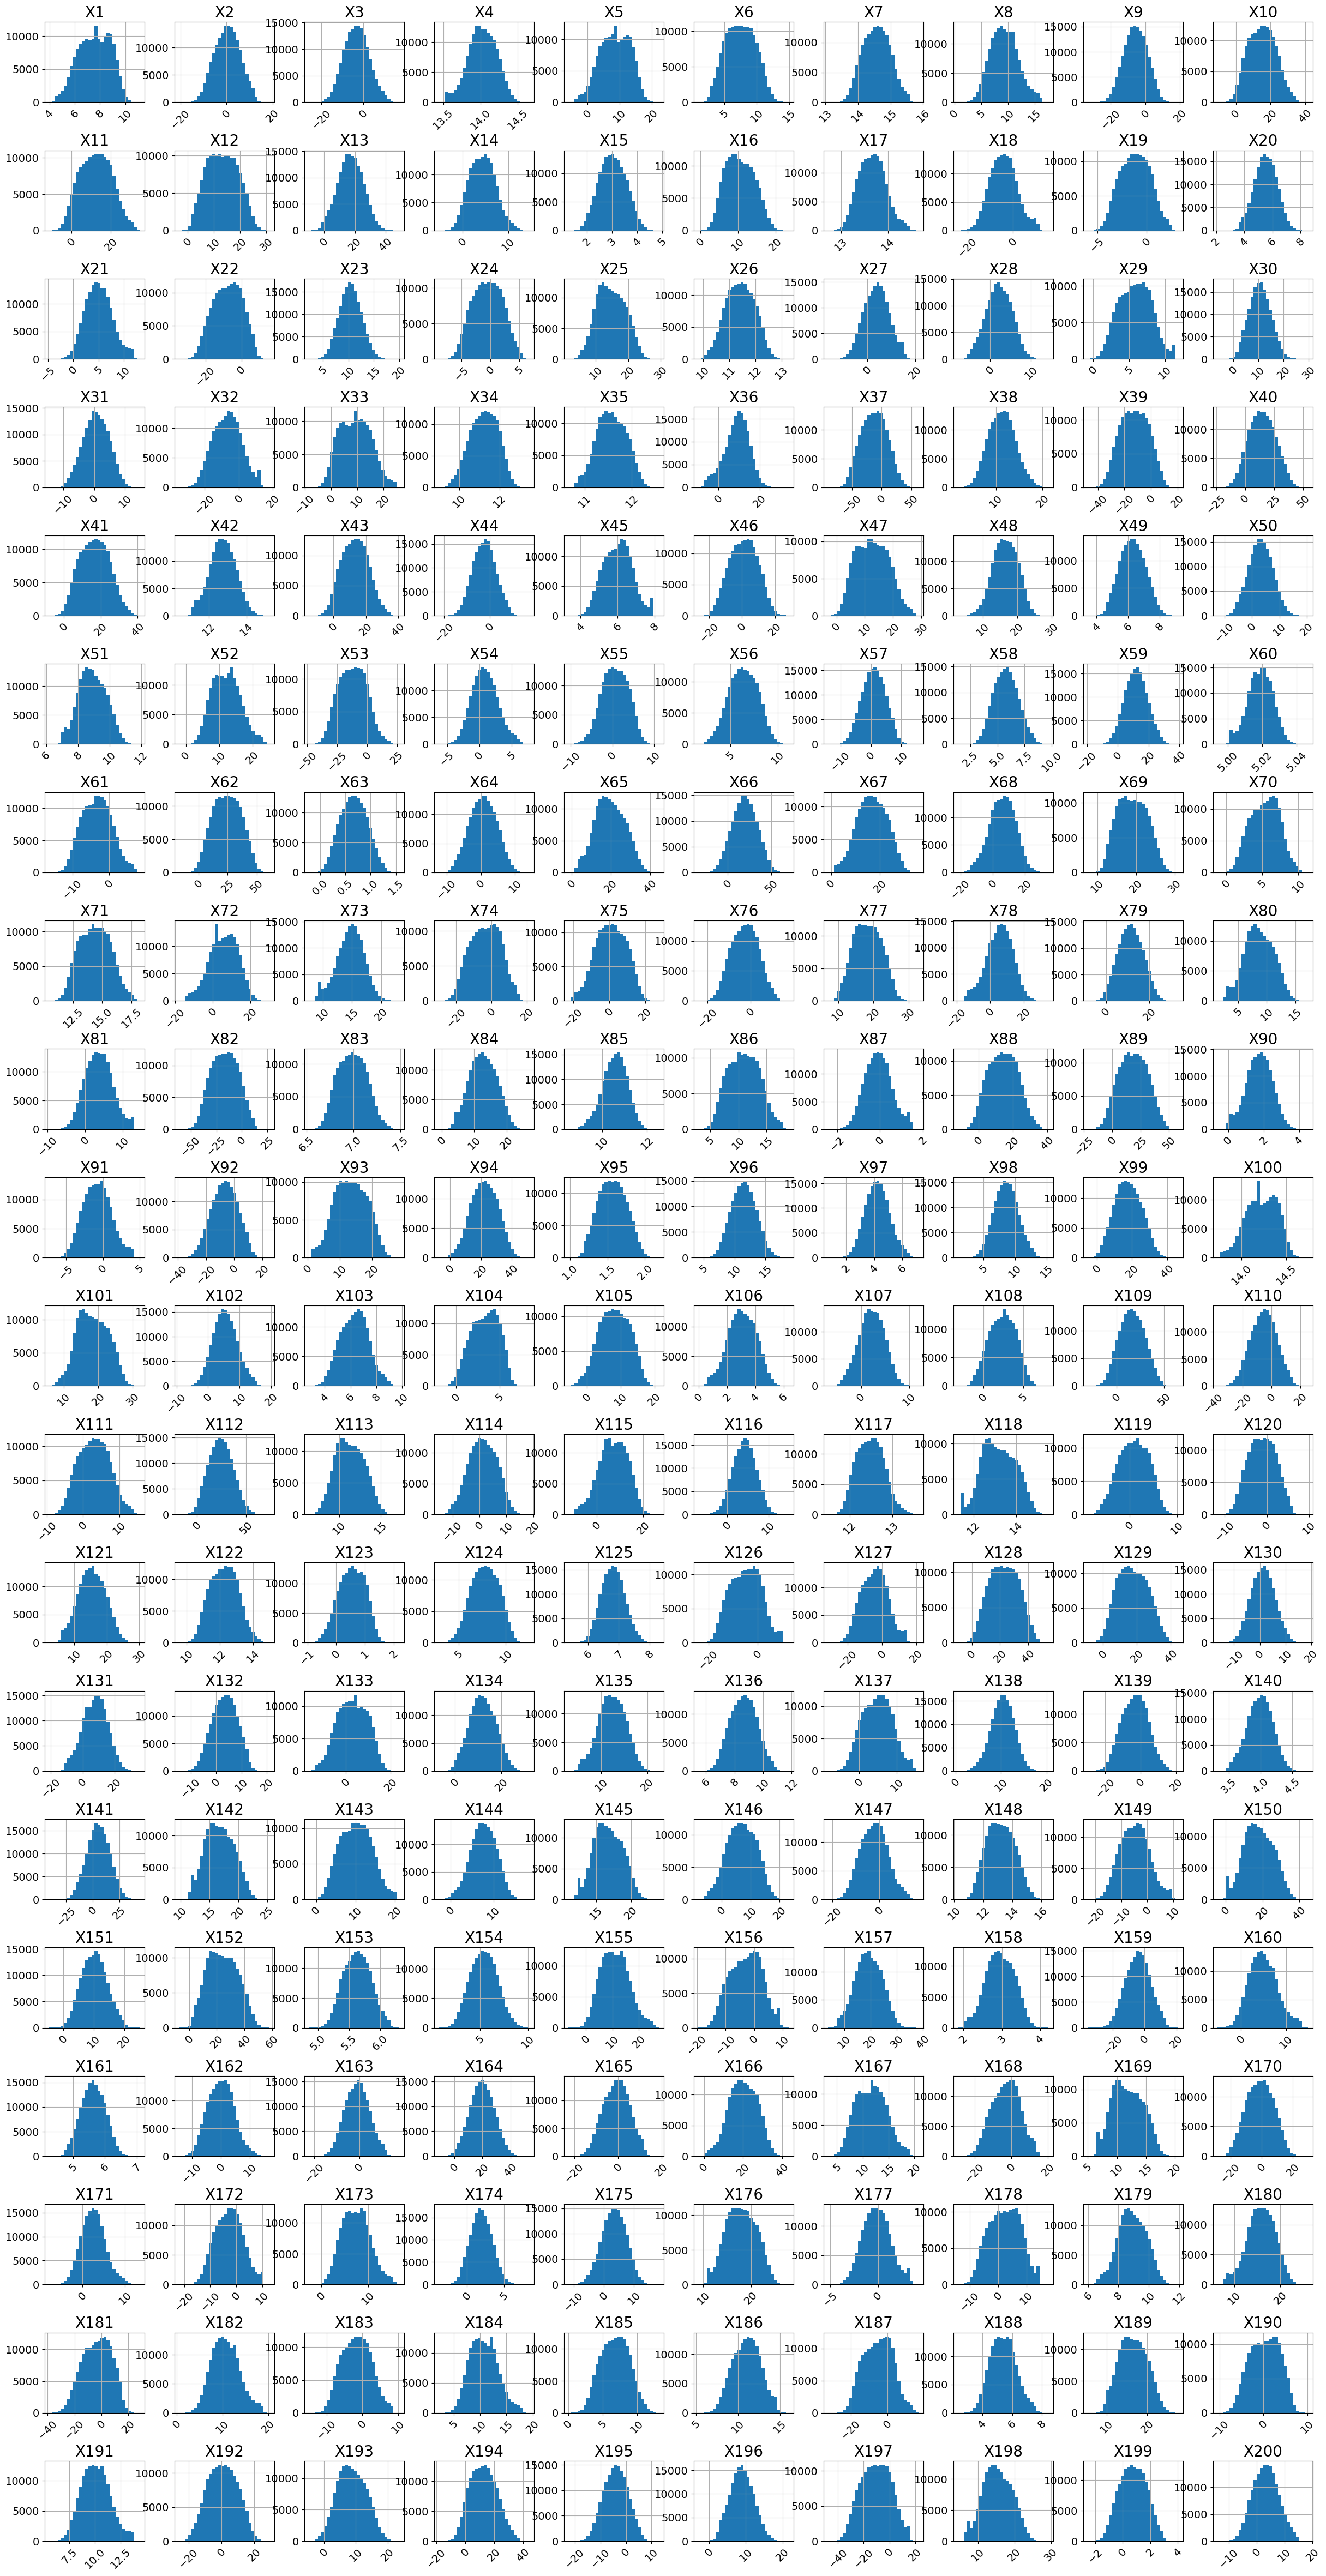

In [32]:
num_features = len(numerical_features)

cols = 10 # no of plots per row
rows = math.ceil(num_features / cols)

# Setup grid layout
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 3 * rows))  # adjust nrows/ncols as needed
axes = axes.flatten()

# Plot each feature histogram
for i, col in enumerate(numerical_features):
    data[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col, fontsize=20)
    axes[i].tick_params(axis='x', labelsize=14, rotation=45)
    axes[i].tick_params(axis='y', labelsize=14)
    axes[i].locator_params(axis='x', nbins=4)
    axes[i].locator_params(axis='y', nbins=4)

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

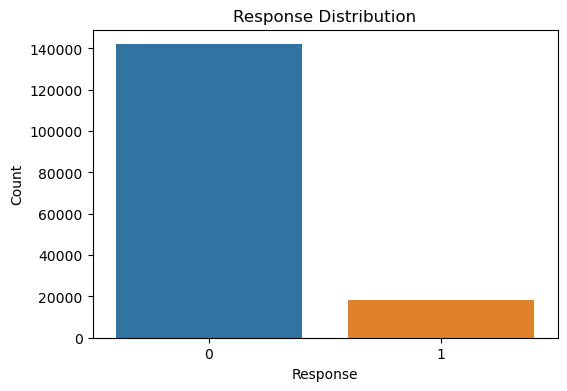

In [33]:
# Response distribution plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Response', data=y_dataset.to_frame())
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Response Distribution')
plt.show()

In [50]:
# imputating the data to handle null values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_dataset)
y_imputed = y_dataset.values

# preprocessing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# selection of features
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X_scaled, y_imputed)

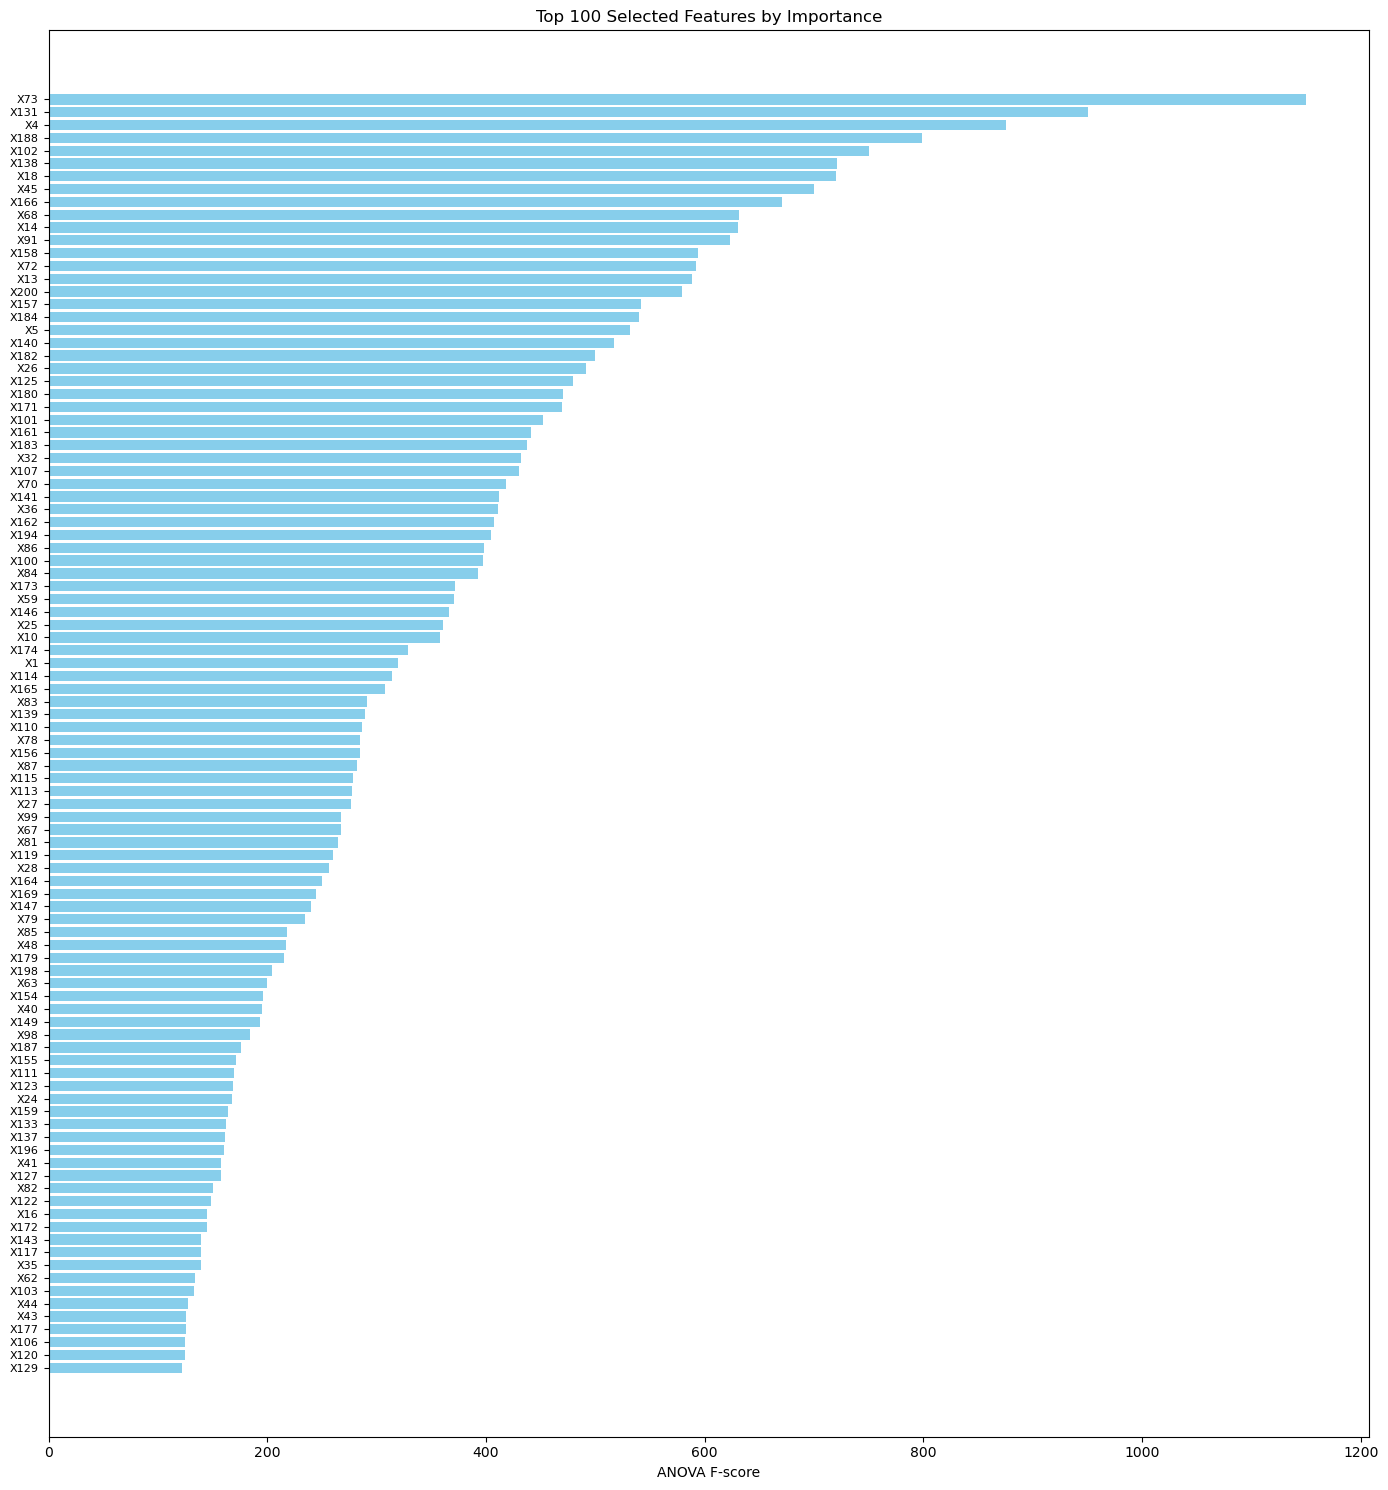

In [35]:
# get mask of selected features
mask = selector.get_support()

# extracting selected feature names and scores
selected_features = X_dataset.columns[mask]
selected_scores = selector.scores_[mask]

# sorting by score (for better visuals)
sorted_indices = np.argsort(selected_scores)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Plot
plt.figure(figsize=(14, 15))
plt.barh(sorted_features, sorted_scores, color='skyblue')
plt.xlabel("ANOVA F-score")
plt.title("Top 100 Selected Features by Importance")
plt.gca().invert_yaxis()  # Highest score at the top
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

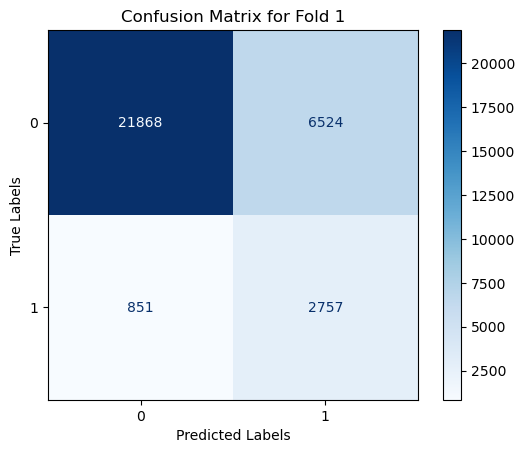

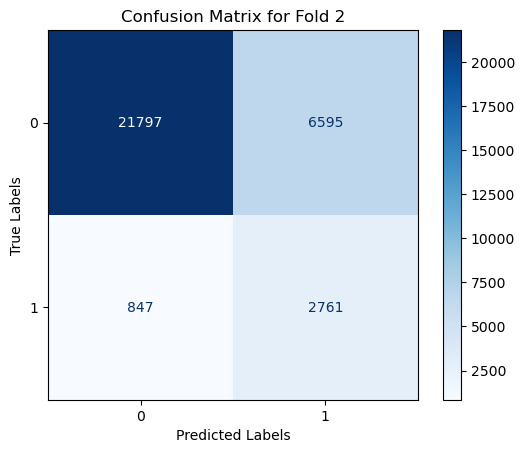

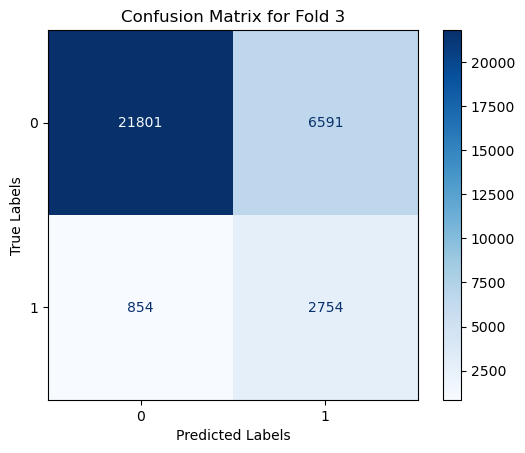

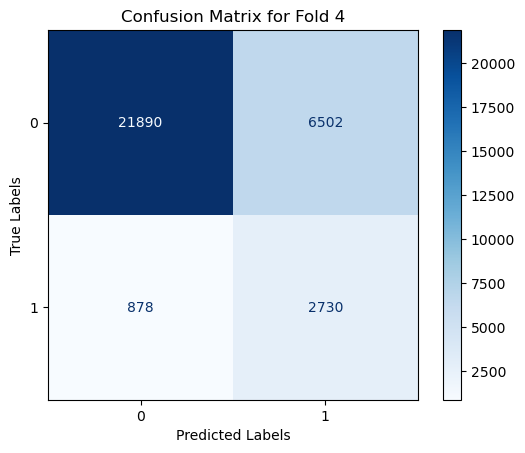

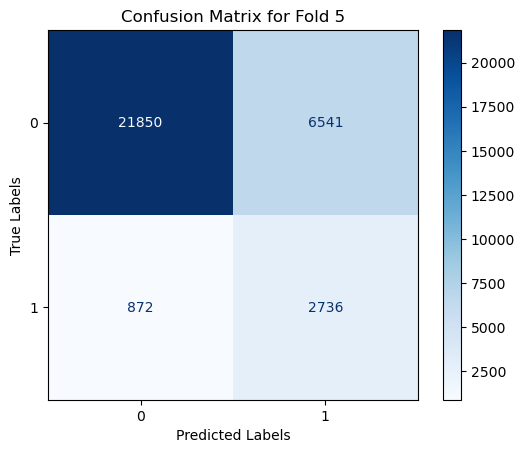

In [85]:
# model-selection and training using k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
precisions,recalls = [], []
average_precisions = []
fprS, tprS, roc_aucS = [], [], []
reports = []

for i, (train_index, test_index) in enumerate(kf.split(X_selected, y_imputed)):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y_imputed[train_index], y_imputed[test_index]

    # using Logistic Regression to fit the model
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # predicting the response
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # predicted probability

    # evaluating accuracy for each fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # evaluating precision, recall curve for each fold
    precision, recall, _ = precision_recall_curve(y_test,y_prob)
    average_precision = average_precision_score(y_test, y_prob)

    recalls.append(recall)
    precisions.append(precision)
    average_precisions.append(average_precision)

    # evaluating ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    fprS.append(fpr)
    tprS.append(tpr)

    # evaluating ROC AUC score for each fold
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_aucS.append(roc_auc)

    # evaluating classification report for each fold
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

    # confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot for confusion matrix (regular - '0', fradulent - '1')
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1]).plot(
        cmap='Blues',
        colorbar=True
    )
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.grid(False)
    plt.show()

Average Accuracy: 0.7684048021031907


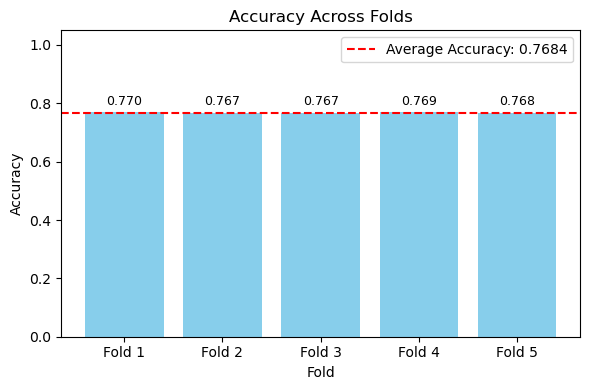

In [86]:
# calculating average accuracy across folds
avg_accuracy = np.mean(accuracies)
print("Average Accuracy:", avg_accuracy)

# bar plot of average accuracy across folds
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(accuracies)), accuracies, color='skyblue')
ax.set_title('Accuracy Across Folds')
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(len(accuracies)))
ax.set_xticklabels([f'Fold {i+1}' for i in range(len(accuracies))])
ax.set_ylim(0, 1.05)
ax.axhline(y=avg_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {avg_accuracy:.4f}')
# Annotate bars with accuracy values
for i, val in enumerate(accuracies):
    ax.text(i, val + 0.015, f'{val:.3f}', ha='center', va='bottom', fontsize=9)
ax.legend()

plt.tight_layout()
plt.show()

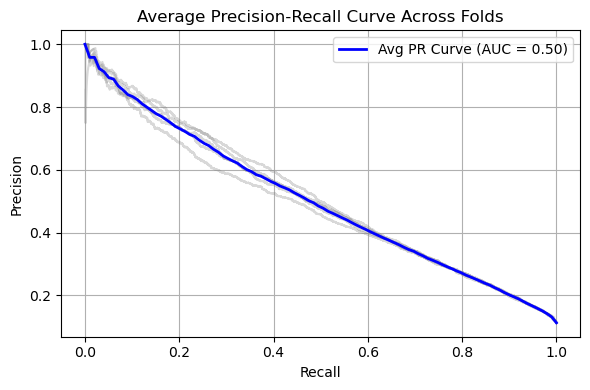

In [88]:
# uniform recall grid
recall_grid = np.linspace(0, 1, 100)

# interpolate each precision curve to common recall grid
interp_precisions = [np.interp(recall_grid, r[::-1], p[::-1]) for p, r in zip(precisions, recalls)]

# average interpolated curves
avg_precision_curve = np.mean(interp_precisions, axis=0)

# PR AUC using interpolated average
pr_auc = auc(recall_grid, avg_precision_curve)

# Plot
plt.figure(figsize=(6, 4))
for p, r in zip(precisions, recalls):
    plt.plot(r, p, color='gray', alpha=0.3)
plt.plot(recall_grid, avg_precision_curve, color='blue', lw=2, label=f'Avg PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision-Recall Curve Across Folds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

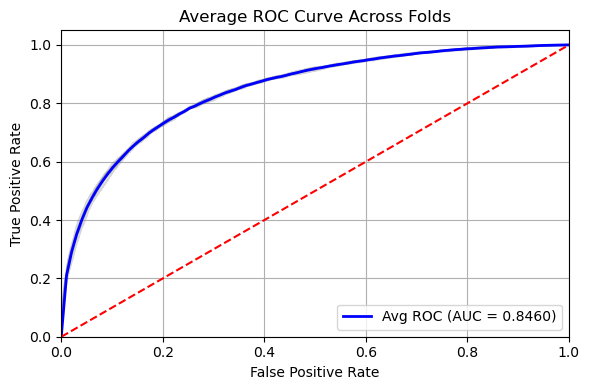

In [90]:
# Define common FPR grid
fpr_grid = np.linspace(0, 1, 100)

# Interpolate TPR for each fold at this FPR grid
interp_tprs = [np.interp(fpr_grid, fpr, tpr) for fpr, tpr in zip(fprS, tprS)]

# Average TPRs
avg_tpr = np.mean(interp_tprs, axis=0)

# Average ROC AUC
avg_roc_auc = np.mean(roc_aucS)

plt.figure(figsize=(6, 4))

# Plot each fold
for fpr, tpr in zip(fprS, tprS):
    plt.plot(fpr, tpr, color='gray', alpha=0.3)

# Plot the averaged curve
plt.plot(fpr_grid, avg_tpr, color='blue', lw=2, label=f'Avg ROC (AUC = {avg_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve Across Folds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# Generating classification report for each fold
# for i in range(len(reports)):
#   report_df = pd.DataFrame(reports[i]).transpose()

#   # Plot for classification report
#   plt.figure(figsize=(6, 4))
#   sns.heatmap(report_df.iloc[:, :].astype(float), annot=True, cmap='Blues', fmt='.2f')
#   plt.title(f'Classification Report for Fold {i}')
#   plt.show()

from tabulate import tabulate

for i in range(len(reports)):
    report_df = pd.DataFrame(reports[i]).transpose()
    print(f"\n=== Classification Report for Fold {i} ===")
    print(tabulate(report_df, headers='keys', tablefmt='pretty', floatfmt=".3f"))


=== Classification Report for Fold 0 ===
+--------------+--------------------+--------------------+--------------------+------------+
|              |     precision      |       recall       |      f1-score      |  support   |
+--------------+--------------------+--------------------+--------------------+------------+
|      0       | 0.9625423654210132 | 0.7702169625246549 | 0.8557062080569741 |  28392.0   |
|      1       | 0.2970585066264411 | 0.7641352549889135 | 0.4278066568391652 |   3608.0   |
|   accuracy   |     0.76953125     |     0.76953125     |     0.76953125     | 0.76953125 |
|  macro avg   | 0.6298004360237272 | 0.7671761087567842 | 0.6417564324480696 |  32000.0   |
| weighted avg | 0.8875090603419252 |     0.76953125     | 0.8074605336571661 |  32000.0   |
+--------------+--------------------+--------------------+--------------------+------------+

=== Classification Report for Fold 1 ===
+--------------+--------------------+--------------------+--------------------+

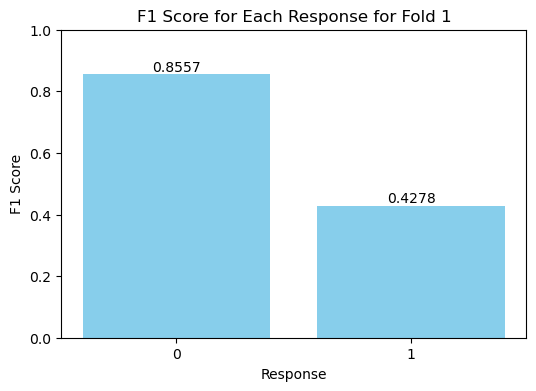

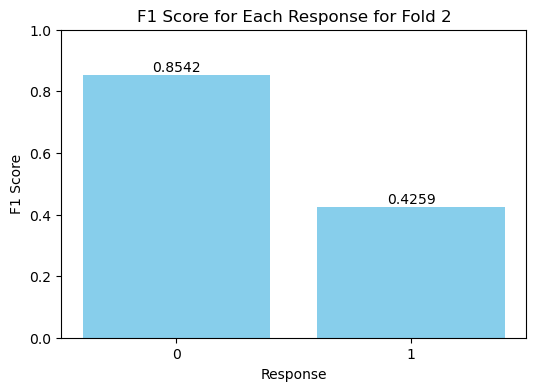

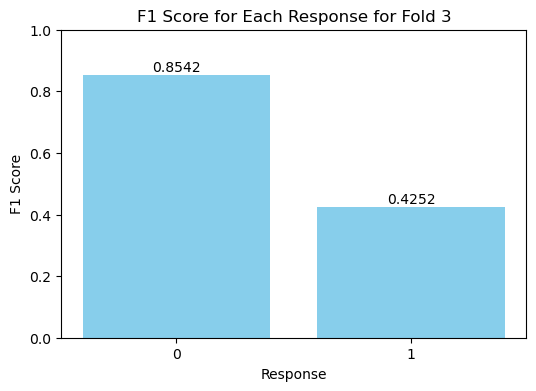

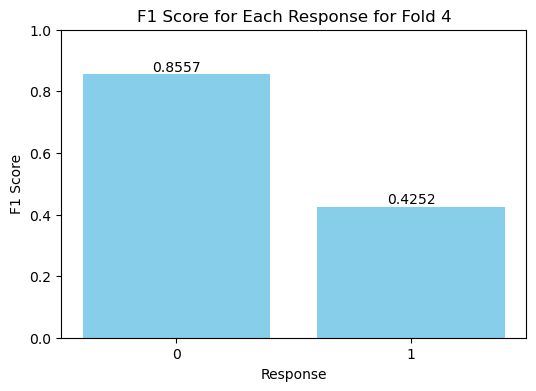

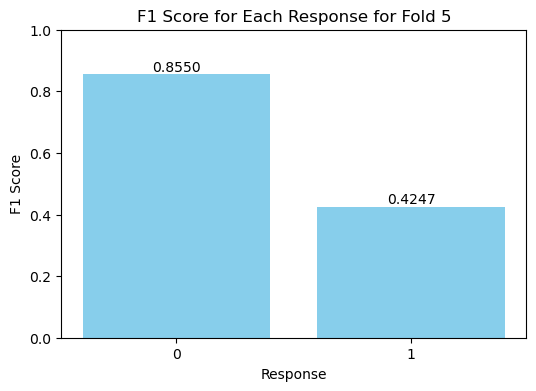

In [92]:
# extracting F1 score for each class
for i in range(len(reports)):
  classes = list(reports[i].keys())[:-3]  # excluding 'accuracy', 'macro avg', and 'weighted avg'
  f1_scores = [reports[i][class_]['f1-score'] for class_ in classes]

  # Plot for F1 score of each class (0 - regular, 1 - fradulent)
  plt.figure(figsize=(6, 4))
  bars = plt.bar(classes, f1_scores, color='skyblue')
  plt.xlabel('Response')
  plt.ylabel('F1 Score')
  plt.title(f'F1 Score for Each Response for Fold {i+1}')
  plt.xticks(rotation=0)
  plt.ylim([0.0, 1.0])

  # Annotate each bar with its corresponding F1 score
  for bar, score in zip(bars, f1_scores):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.4f}', ha='center')

  plt.show()

In [66]:
########### Using Extreme Gradient Boosting ###############################################################################################################################

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [70]:
# Split your data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_imputed, test_size=0.2, stratify=y_imputed, random_state=42
)

# Compute class imbalance ratio
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

In [71]:
# Define the XGBoost classifier
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Predict class labels and probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89     28392
           1       0.35      0.69      0.47      3608

    accuracy                           0.82     32000
   macro avg       0.65      0.76      0.68     32000
weighted avg       0.89      0.82      0.85     32000

Confusion Matrix:
 [[23876  4516]
 [ 1134  2474]]
ROC AUC Score: 0.8515676933682328


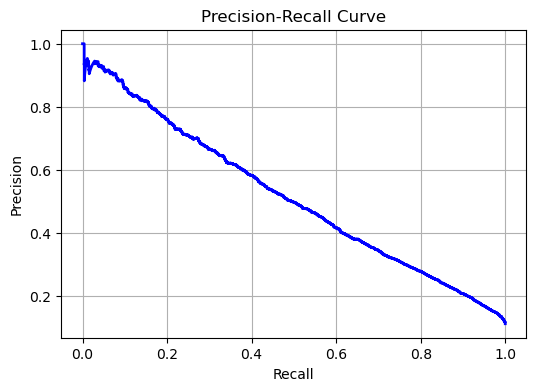

In [72]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()